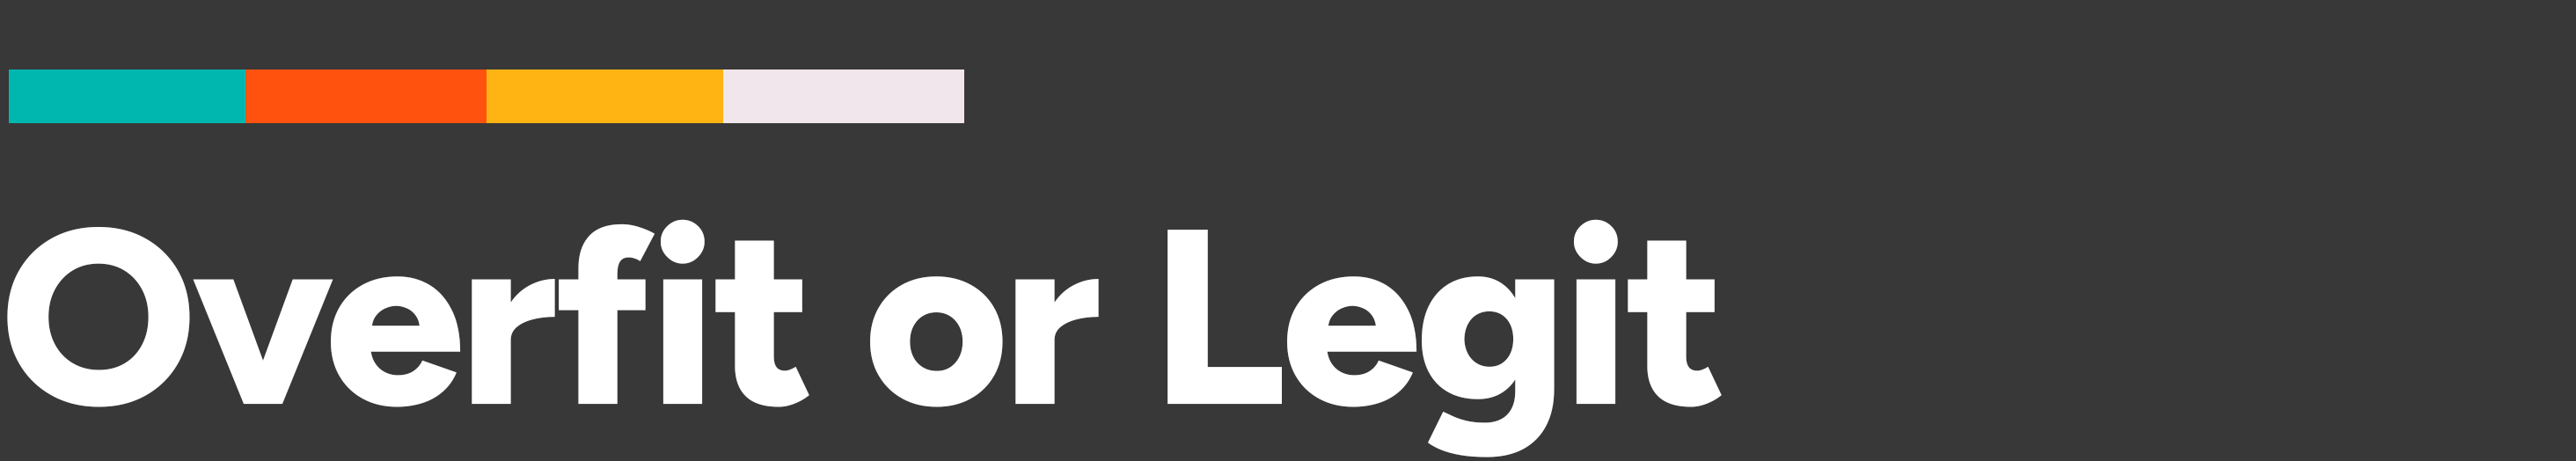

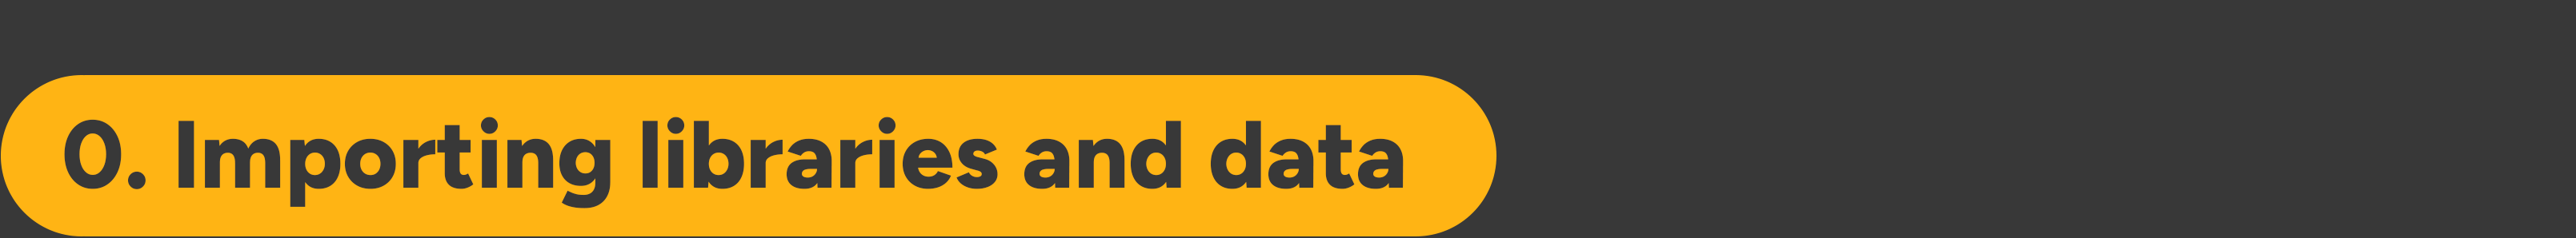

In [79]:
import glob
import os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import ta
from statsmodels.tsa.stattools import adfuller, kpss
from tsfracdiff import FractionalDifferentiator
from hmmlearn import hmm

sns.set(style='dark', palette='viridis')

In [80]:
directory_path = 'forex_lite'
files = glob.glob(os.path.join(directory_path, '*.csv'))

forex = pd.DataFrame()
content = []
for i in files:
    df = pd.read_csv(i, index_col='Date', header=0)
    content.append(df)

forex = pd.concat(content, axis=1)
forex.dropna(inplace=True)
forex.index = pd.to_datetime(forex.index)

forex

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18 22:05:00,0.98401,99.159,93.246,123.528,1.88498,78.817,5.79210,28.950
2013-03-18 22:10:00,0.98431,99.167,93.245,123.507,1.88536,78.815,5.79153,28.947
2013-03-18 22:15:00,0.98440,99.157,93.231,123.536,1.88551,78.810,5.79213,28.956
2013-03-18 22:20:00,0.98448,99.182,93.206,123.531,1.88563,78.822,5.79259,28.970
2013-03-18 22:25:00,0.98445,99.229,93.179,123.589,1.88564,78.853,5.79234,28.963
...,...,...,...,...,...,...,...,...
2024-05-07 10:05:00,0.59906,101.990,112.977,166.347,1.69644,92.828,10.86585,27.204
2024-05-07 10:10:00,0.59900,101.995,112.965,166.364,1.69645,92.822,10.86554,27.205
2024-05-07 10:15:00,0.59904,102.016,112.973,166.376,1.69645,92.828,10.86469,27.194


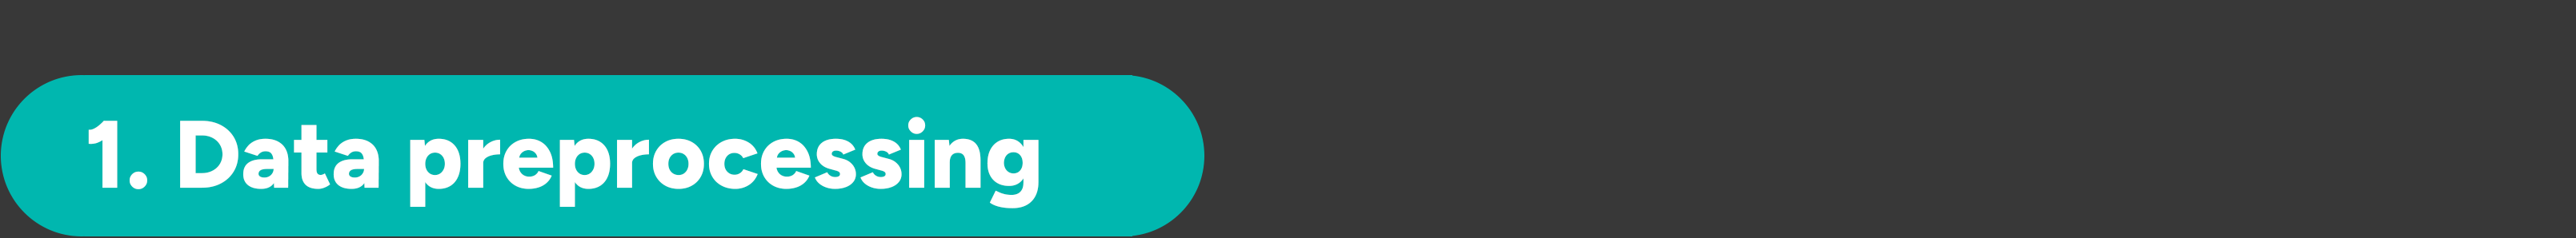

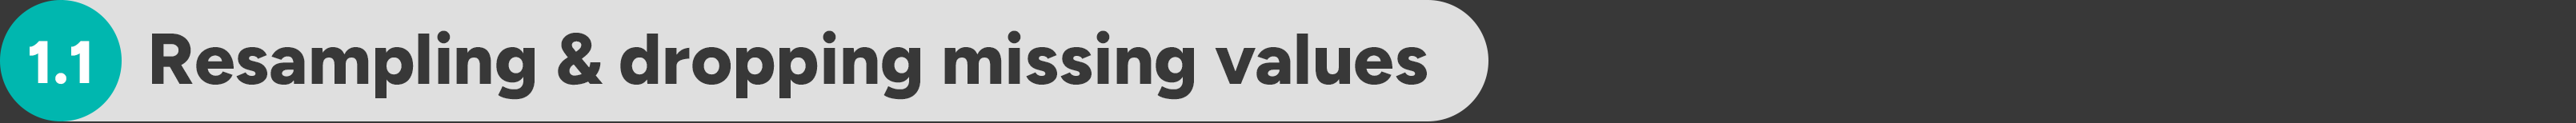

Resampling (5 min interval to daily interval) + dropping nans (for non trading days)

In [81]:
forex_daily = forex.resample('D').mean()
forex_daily.dropna(inplace = True)
forex_daily

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,0.984021,99.262391,93.292261,123.700739,1.884967,78.868826,5.790434,28.954870
2013-03-19,0.981480,98.808842,92.990419,123.070242,1.888079,78.514902,5.811537,28.906283
2013-03-20,0.981423,99.142725,93.016902,123.387845,1.890114,78.578057,5.834484,28.871717
2013-03-21,0.984902,99.279198,93.104660,123.166794,1.893798,79.167710,5.840223,29.031668
2013-03-22,0.984958,98.788456,92.445386,122.543539,1.898793,78.859048,5.823279,28.945592
...,...,...,...,...,...,...,...,...
2024-05-02,0.597146,101.196609,112.853420,165.721609,1.700319,91.842667,11.030503,26.531112
2024-05-03,0.597832,100.827510,111.892904,164.429801,1.696113,91.616701,10.913880,26.522653
2024-05-05,0.598583,101.322600,111.973850,164.920150,1.693584,92.095900,10.846253,26.559250


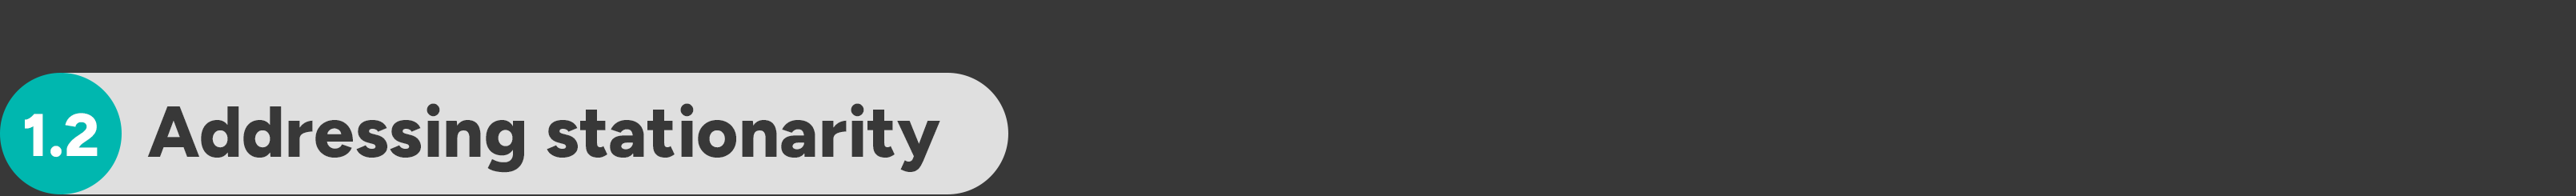

Stationarity is a necessary, non-sufficient condition for the high performance of an ML algorithm.

**PROBLEM**: there is a trade-off between stationarity and memory.
* too much differencing = stationary BUT no memory

**SOLUTION**: use fractional differencing, i.e. minimum degree of differencing, just enuf to pass adf test

Visual inspection

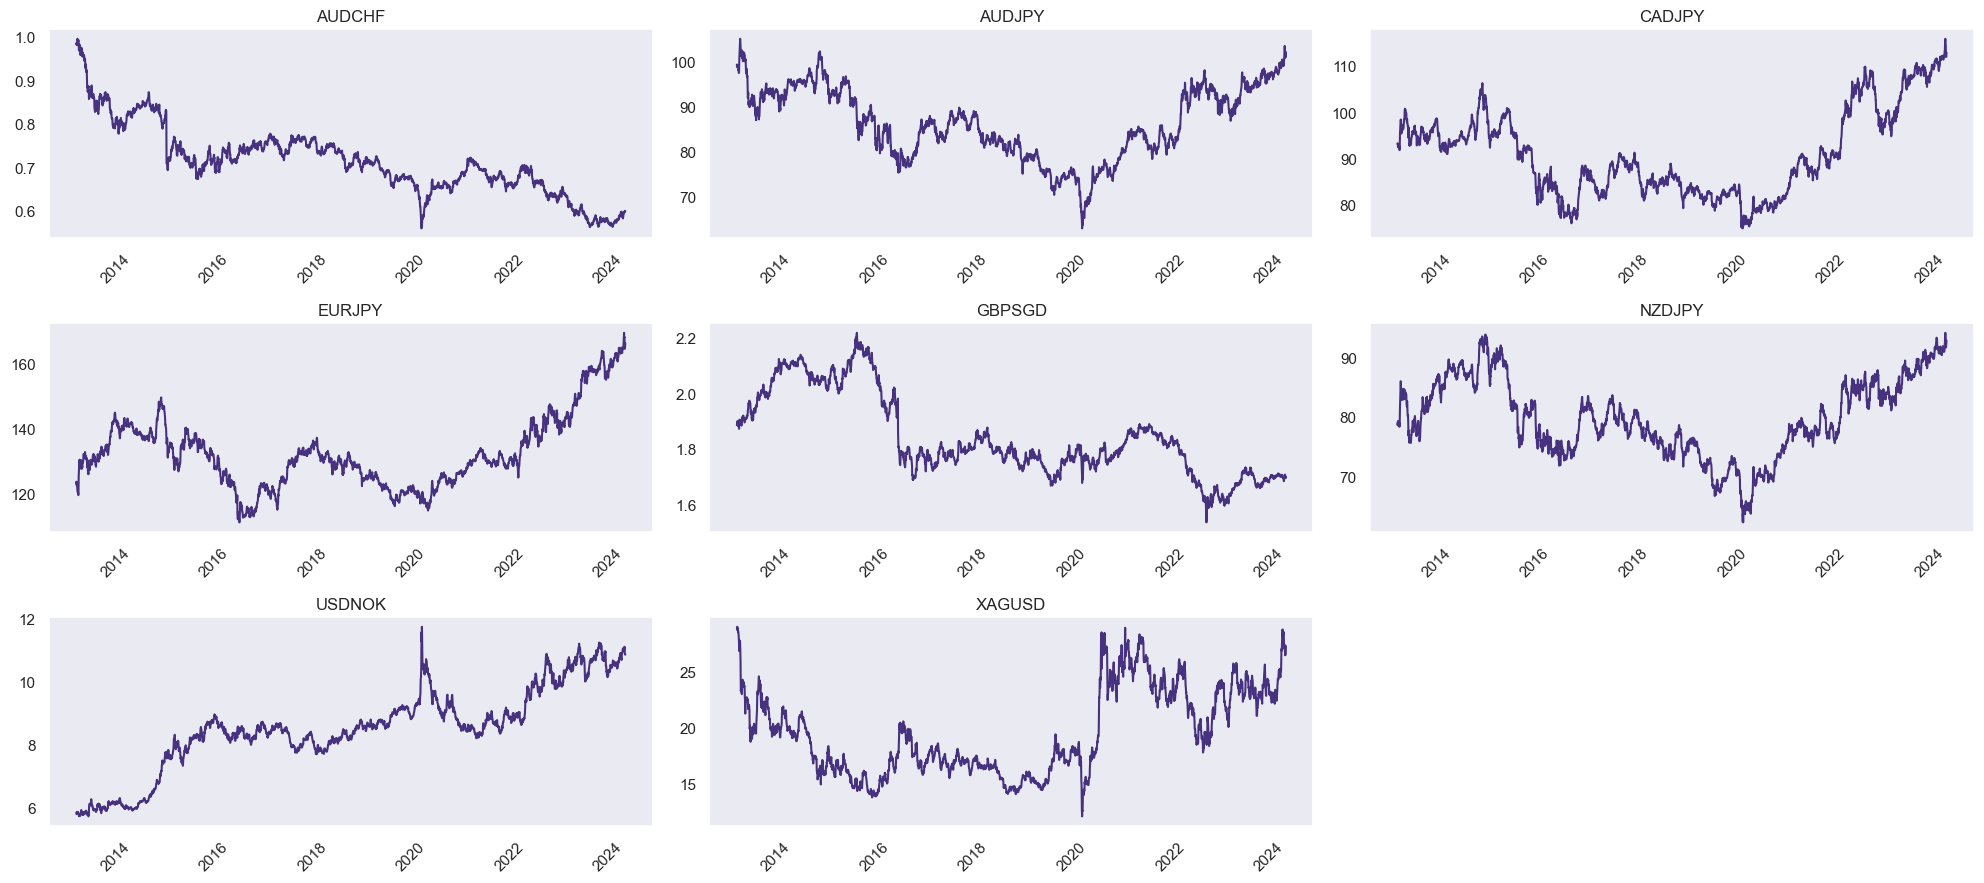

In [82]:
num_plots = len(forex_daily.columns)
nrows = (num_plots // 3) + (1 if num_plots % 3 else 0)
ncols = min(3, num_plots)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, 9))

axes = axes.flatten()

for i, column in enumerate(forex_daily.columns):
    axes[i].plot(forex_daily.index, forex_daily[column])
    axes[i].set_title(column)
    axes[i].tick_params(axis = "x", rotation = 45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

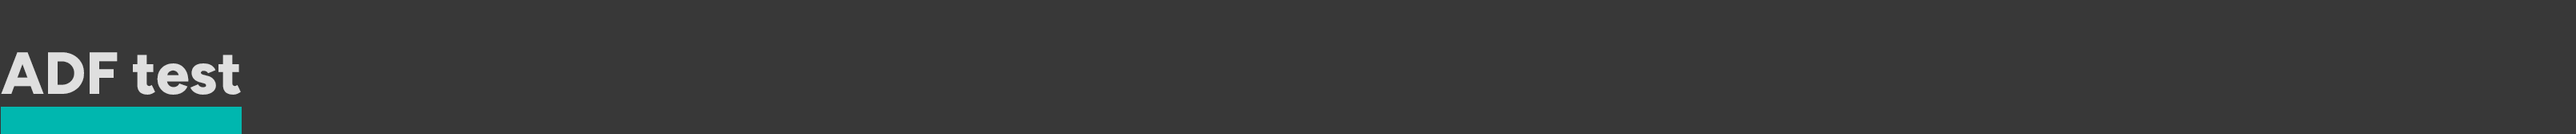

In [83]:
adf_results = []
for pair in forex_daily.columns:
    result = adfuller(forex_daily[pair])
    adf_stat = result[0]
    p = result[1]
    adf_results.append((pair, adf_stat, p))

adf_results = pd.DataFrame(adf_results, columns = ['pair', 'adf_stat', 'p'])
display(adf_results)
print(f'\nNumber of pairs with a p-value < 0.05: {sum(adf_results.p < 0.05)} out of {len(adf_results)} pairs.')
adf_non_stationary = adf_results[adf_results["p"] < 0.05].reset_index(drop = True)
adf_non_stationary

,pair,adf_stat,p
0,AUDCHF,-3.040725,0.031262
1,AUDJPY,-1.902124,0.331063
2,CADJPY,-0.940435,0.774365
3,EURJPY,-0.570026,0.877612
4,GBPSGD,-1.360763,0.600935
5,NZDJPY,-1.763264,0.398847
6,USDNOK,-1.464127,0.551177
7,XAGUSD,-2.500256,0.115412



Number of pairs with a p-value < 0.05: 1 out of 8 pairs.


,pair,adf_stat,p
0,AUDCHF,-3.040725,0.031262


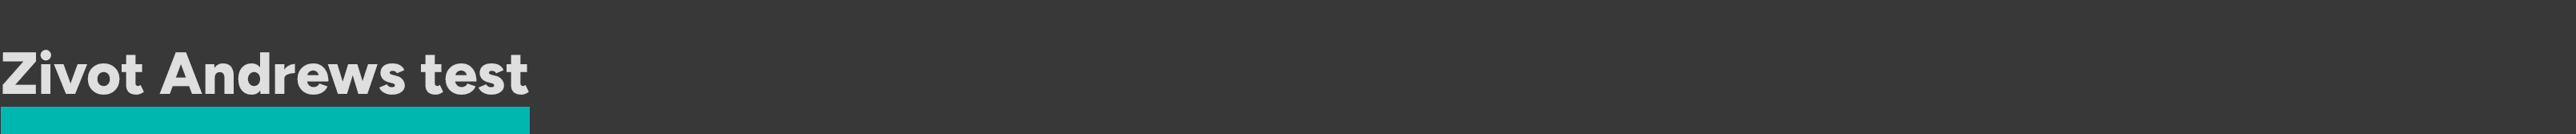

Address adf test's issue by accounting for single structural breaks

In [84]:
from arch.unitroot import ZivotAndrews

za_results = []

for pair in forex_daily.columns:
    za = ZivotAndrews(forex_daily[pair])
    p = za.pvalue
    stat = za.stat
    za_results.append((pair, stat, p))

za_results = pd.DataFrame(za_results, columns = ['pair', 'za_stat', 'p'])
display(za_results)

print(f'\nNumber of pairs with a p-value < 0.05: {sum(za_results.p < 0.05)} out of {len(za_results)} pairs.')
za_non_stationary = za_results[za_results["p"] < 0.05].reset_index(drop = True)
za_non_stationary

,pair,za_stat,p
0,AUDCHF,-4.816294,0.049369
1,AUDJPY,-3.599176,0.614633
2,CADJPY,-3.441184,0.716414
3,EURJPY,-3.298552,0.796055
4,GBPSGD,-4.579112,0.097066
5,NZDJPY,-3.492986,0.684153
6,USDNOK,-3.823301,0.463739
7,XAGUSD,-6.037815,0.000786



Number of pairs with a p-value < 0.05: 2 out of 8 pairs.


,pair,za_stat,p
0,AUDCHF,-4.816294,0.049369
1,XAGUSD,-6.037815,0.000786


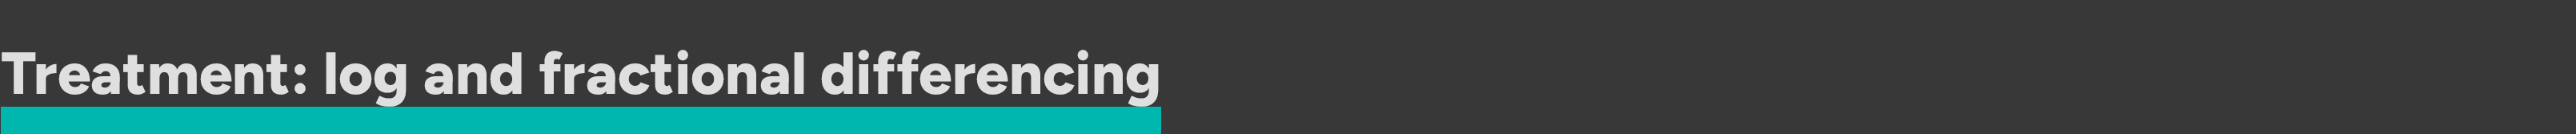

Source: textbook page 160, 161

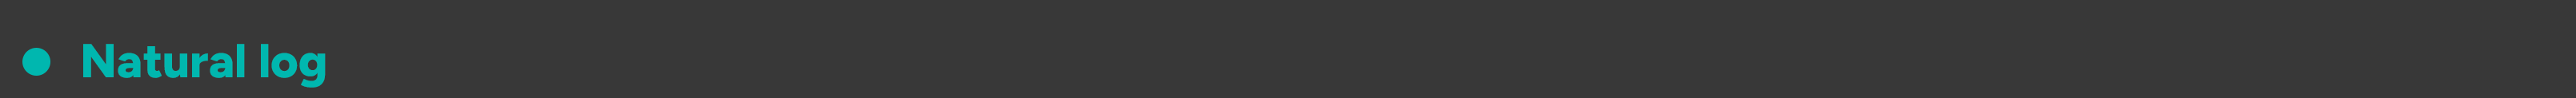

In [85]:
forex_daily_log = np.log(forex_daily)
forex_daily_log.head(2)

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,-0.016108,4.597767,4.535737,4.817865,0.633911,4.367786,1.756207,3.365738
2013-03-19,-0.018693,4.593187,4.532496,4.812755,0.635560,4.363288,1.759845,3.364059


Since the values of AUDCHF is too close to zero -> negative log prices. Fix: **translation** - adding a constant to value b4 taking log.

In [86]:
a = 1 - np.min(forex_daily)
forex_daily_log = np.log(forex_daily + a)
forex_daily_log

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,0.353764,4.602194,4.540447,4.821419,0.843877,4.373354,1.829510,3.380834
2013-03-19,0.351979,4.597634,4.537221,4.816327,0.845214,4.368882,1.832891,3.379179
2013-03-20,0.351938,4.600993,4.537505,4.818895,0.846088,4.369681,1.836555,3.378001
2013-03-21,0.354382,4.602362,4.538443,4.817109,0.847667,4.377116,1.837469,3.383443
2013-03-22,0.354421,4.597429,4.531371,4.812054,0.849805,4.373231,1.834767,3.380518
...,...,...,...,...,...,...,...,...
2024-05-02,0.036857,4.621408,4.729985,5.112963,0.761141,4.524861,2.439813,3.294781
2024-05-03,0.037517,4.617770,4.721470,5.105158,0.759174,4.522409,2.429595,3.294467
2024-05-05,0.038241,4.622647,4.722191,5.108128,0.757989,4.527601,2.423621,3.295824


Checking to see if logging has stabilise the data enuf:

In [87]:
logged_adf_results = []
for pair in forex_daily.columns:
    result = adfuller(forex_daily_log[pair])
    logged_adf_stat = result[0]
    p = result[1]
    logged_adf_results.append((pair, logged_adf_stat, p))

logged_adf_results = pd.DataFrame(logged_adf_results, columns = ['pair', 'logged_adf_stat', 'p'])
display(logged_adf_results)
print(f'\nNumber of pairs with a p-value < 0.05: {sum(logged_adf_results.p < 0.05)} out of {len(logged_adf_results)} pairs.')
logged_adf_non_stationary = logged_adf_results[logged_adf_results["p"] < 0.05].reset_index(drop = True)

,pair,logged_adf_stat,p
0,AUDCHF,-2.737852,0.067714
1,AUDJPY,-1.919301,0.323037
2,CADJPY,-1.083458,0.721624
3,EURJPY,-0.835126,0.808586
4,GBPSGD,-1.390507,0.586819
5,NZDJPY,-1.806619,0.377180
6,USDNOK,-1.687895,0.437360
7,XAGUSD,-2.593450,0.094359



Number of pairs with a p-value < 0.05: 0 out of 8 pairs.


Cos it's pretty much stationary now -> no need for frac diff (that is if we use ADF fuller test result as a benchmark)

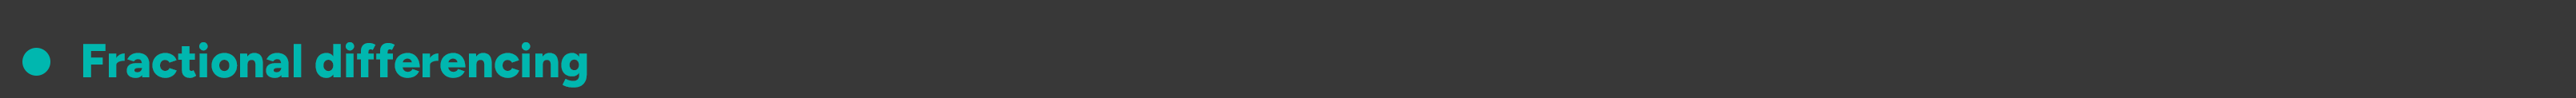

might delete later

In [88]:
frac_diff_price_df = forex_daily_log.copy()
fracDiff = FractionalDifferentiator()

for pair in logged_adf_non_stationary.pair.values[:]:
    frac_diff_price_df[pair] = fracDiff.FitTransform(forex_daily[pair])
display(frac_diff_price_df)

nan_counts = frac_diff_price_df.isnull().sum()
columns_with_nans = [nan_counts[nan_counts > 0]]
print("Number of columns with NaN values:")
columns_with_nans

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18,0.353764,4.602194,4.540447,4.821419,0.843877,4.373354,1.829510,3.380834
2013-03-19,0.351979,4.597634,4.537221,4.816327,0.845214,4.368882,1.832891,3.379179
2013-03-20,0.351938,4.600993,4.537505,4.818895,0.846088,4.369681,1.836555,3.378001
2013-03-21,0.354382,4.602362,4.538443,4.817109,0.847667,4.377116,1.837469,3.383443
2013-03-22,0.354421,4.597429,4.531371,4.812054,0.849805,4.373231,1.834767,3.380518
...,...,...,...,...,...,...,...,...
2024-05-02,0.036857,4.621408,4.729985,5.112963,0.761141,4.524861,2.439813,3.294781
2024-05-03,0.037517,4.617770,4.721470,5.105158,0.759174,4.522409,2.429595,3.294467
2024-05-05,0.038241,4.622647,4.722191,5.108128,0.757989,4.527601,2.423621,3.295824


Number of columns with NaN values:


[Series([], dtype: int64)]

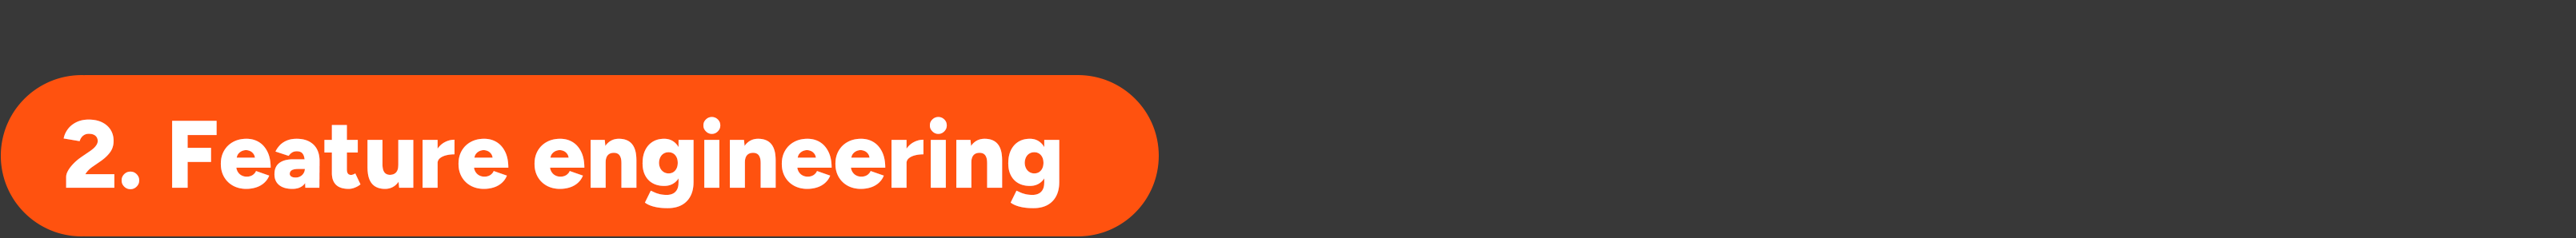

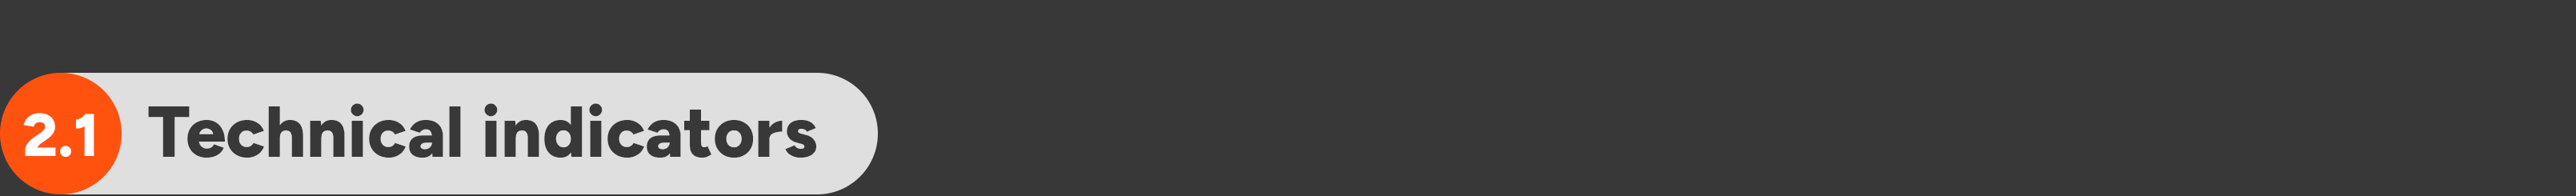

Lets just pick out AUDCHF as an example to see how the `features` df is formed for each price path.

In [89]:
# Pick out a single path to demonstrate how the features df is created
AUDCHF = forex_daily['AUDCHF']
features_AUDCHF = pd.DataFrame()

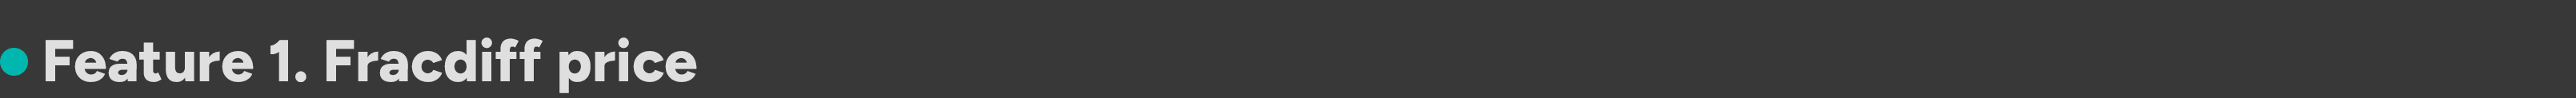

will delete later

In [90]:
features_AUDCHF['frac_diff'] = frac_diff_price_df['AUDCHF']

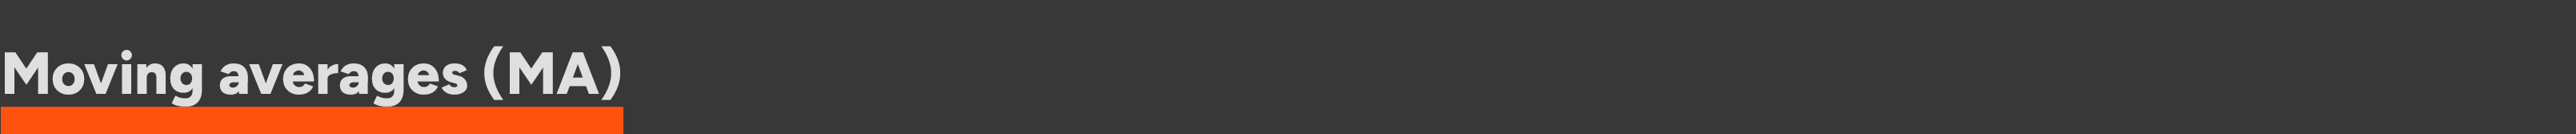

Simple moving average (sma), exponential moving average (ema)

Consider: integrated window moving average (iwma)

In [91]:
features_AUDCHF['sma_10'] = ta.trend.sma_indicator(AUDCHF, window=10)
features_AUDCHF['sma_20'] = ta.trend.sma_indicator(AUDCHF, window=20)

features_AUDCHF['ema_10'] = ta.trend.ema_indicator(AUDCHF, window=10)
features_AUDCHF['ema_20'] = ta.trend.ema_indicator(AUDCHF, window=20)

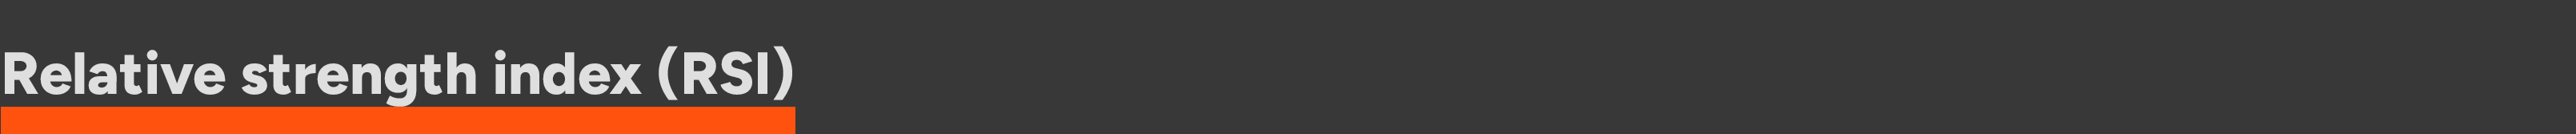

In [92]:
features_AUDCHF['rsi'] = ta.momentum.rsi(AUDCHF)
features_AUDCHF['macd'] = ta.trend.macd_diff(AUDCHF)
features_AUDCHF['bb_upper'], features_AUDCHF['bb_middle'], features_AUDCHF['bb_lower'] = \
    ta.volatility.bollinger_hband_indicator(AUDCHF), ta.volatility.bollinger_mavg(AUDCHF), \
    ta.volatility.bollinger_lband_indicator(AUDCHF)

Normalisation of features

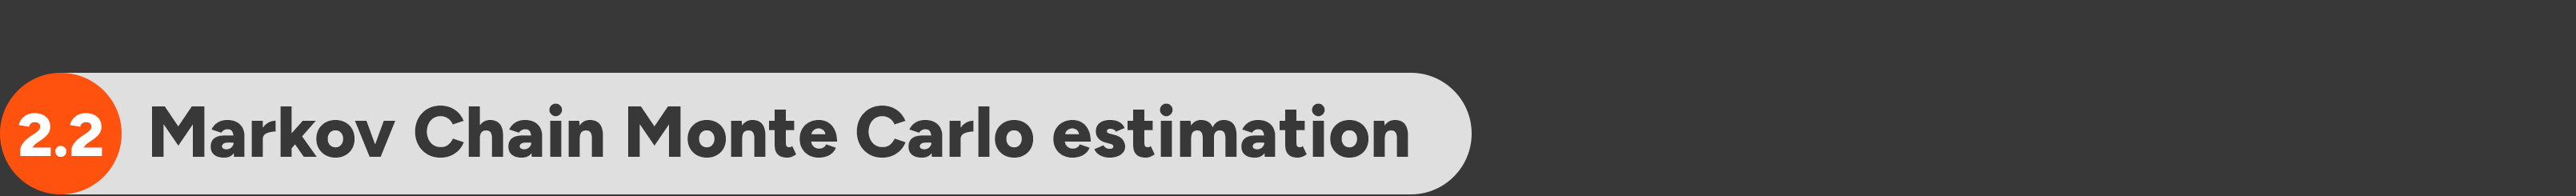

To do
1. Define regimes
2. Create transitn matrix and calibrate inistial and trans probability
3. Simulate

**Types of Regime Switching Models**
1. Markov Switching Autoregressive Model (MS-AR)

2. Markov Switching Vector Autoregressive Model (MS-VAR)

3. Markov Switching GARCH Model (MS-GARCH)

**Estimation**
1. Maximum Likelihood Estimation (MLE)

* most common
2. Expectation-Maximisation (EM)
* E: algorithm calculates the expected value of the complete data log-likelihood, given the observed data and current parameter estimates (State Probabilities & Expected Log-Likelihood)
* M: maximises the expected log-likelihood obtained from the E-step; Update / re-estimate the parameters (e.g., transition probabilities, state-specific means, and variances) to maximise the expected log-likelihood. Iterate until the changes in parameter estimates are sufficiently small, indicating convergence.

3. Baum-Welch algorithm
* specific instance of the EM algorithm used for Hidden Markov Models (HMMs)

**THIS ONE = BAUM WELCH**

https://github.com/tianyu-z/Kritzman-Regime-Detection/tree/master

In [ ]:
or advanced features in forex data analysis, consider using the following techniques beyond traditional technical indicators:

Market Microstructure Features:

Order Flow: Buy and sell order quantities and their impact on price movements.
Order Book Imbalance: The difference between buy and sell orders at different price levels.
Macroeconomic Indicators:

Economic Data Releases: Impact of economic data (e.g., GDP, CPI, unemployment rates) on currency pairs.
Interest Rate Differentials: Differences in interest rates between countries can drive currency movements.
Sentiment Analysis:

News Sentiment: Analysis of news headlines and articles to gauge market sentiment.
Social Media Sentiment: Using social media platforms like Twitter to understand market sentiment.
Volatility Measures:

Realised Volatility: Historical volatility calculated from past price data.
Implied Volatility: Volatility implied by options prices, indicating market expectations of future volatility.
Regime-Switching Models:

Hidden Markov Models (HMM): To identify different market regimes and transitions between them.
Markov Switching GARCH Models: To model volatility regimes in forex returns.
Seasonality and Calendar Effects:

Day-of-Week Effect: Price patterns related to specific days of the week.
Month-of-Year Effect: Seasonal trends based on months or quarters.
Statistical Arbitrage Features:

Pair Trading Signals: Identifying cointegrated currency pairs and trading based on their spread.
Mean Reversion Signals: Indicators based on statistical properties suggesting mean-reverting behaviour.
Intermarket Analysis:

Correlation with Commodities: Examining correlations between currency pairs and commodity prices (e.g., oil, gold).
Cross-Currency Analysis: Relationships and leading signals from other currency pairs.
Machine Learning Features:

Principal Component Analysis (PCA): Reducing dimensionality and capturing the main variance in the data.
Feature Engineering with Deep Learning: Using autoencoders or recurrent neural networks to capture complex patterns.
Event-Driven Features:

Political Events: Impact of elections, policy changes, and geopolitical events on forex prices.
Central Bank Actions: Monitoring and predicting central bank decisions and their impact on currency values.
Liquidity Measures:

Bid-Ask Spread: Measuring the liquidity and transaction costs in the forex market.
Volume and Turnover: Analysis of trading volume and turnover as indicators of market activity.
Advanced Statistical Features:

Fractal Analysis: Using fractal dimensions to understand the self-similarity and complexity of price movements.
Entropy Measures: Quantifying the randomness and uncertainty in forex price series.

### CURRENCY TURBULENCE

In [106]:
AUDCHF = forex_daily_log['AUDCHF']
AUDCHF

Date
2013-03-18    0.353764
2013-03-19    0.351979
2013-03-20    0.351938
2013-03-21    0.354382
2013-03-22    0.354421
                ...   
2024-05-02    0.036857
2024-05-03    0.037517
2024-05-05    0.038241
2024-05-06    0.039296
2024-05-07    0.039265
Name: AUDCHF, Length: 3445, dtype: float64

In [111]:
def fit_hmm(data):
    if isinstance(data, pd.DataFrame):
        data = data.values

    model = hmm.GaussianHMM(n_components = 2, covariance_type = "full")
    model.fit(data)

    hidden_states = model.predict(data)
    state_probs = model.predict_proba(data)
    means = model.means_.flatten()
    variances = [np.sqrt(np.diag(cov)) for cov in model.covars_]

    state_params = pd.DataFrame({
        'State': range(len(means)),
        'Mean': means,
        'Variance': [var[0] for var in variances]
    })

    state_probs_df = pd.DataFrame(state_probs, columns=[f'Probability of state {i}' for i in range(state_probs.shape[1])])

    result_df = pd.DataFrame(data, columns=['Value'])
    result_df = pd.concat([result_df, state_probs_df], axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    sns.lineplot(data=pd.DataFrame({'index': range(len(state_probs[:, 1])), 'Probability': state_probs[:, 1]}), x='index', y='Probability', ax=axs[0])
    axs[0].set_title('Probability of State 1')

    sns.lineplot(data=pd.DataFrame(data, columns=['Value']).reset_index(), x='index', y='Value', ax=axs[1])
    axs[1].set_title('Original Data')

    plt.tight_layout()

    return result_df, state_params

,Value,Probability of state 0,Probability of state 1
0,0.984021,6.039944e-158,1.000000e+00
1,0.981480,1.730467e-18,1.000000e+00
2,0.981423,1.745259e-18,1.000000e+00
3,0.984902,1.037229e-18,1.000000e+00
4,0.984958,1.028537e-18,1.000000e+00
...,...,...,...
3440,0.597146,9.999999e-01,7.702126e-08
3441,0.597832,9.999999e-01,7.911326e-08
3442,0.598583,9.999999e-01,1.217253e-07
3443,0.599681,9.999985e-01,1.496390e-06


,State,Mean,Variance
0,0,0.646288,0.040388
1,1,0.767585,0.061530


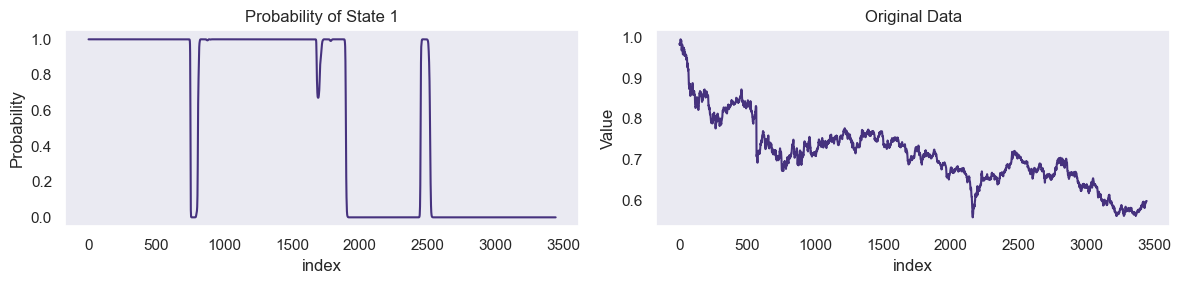

In [110]:
result_df, state_params = fit_hmm(forex_daily[['AUDCHF']])

display(result_df)
display(state_params)

In [ ]:
result_df.iloc[:, 1]

0       1.000000e+00
1       1.000000e+00
2       1.000000e+00
3       1.000000e+00
4       1.000000e+00
            ...     
3440    8.471637e-08
3441    8.693651e-08
3442    1.312850e-07
3443    1.568764e-06
3444    4.839535e-05
Name: Probability of state 0, Length: 3445, dtype: float64

In [ ]:
features_AUDCHF['prob_state_0'] = result_df.iloc[:, 1]
features_AUDCHF['prob_state_1'] = result_df.iloc[:, 2]
features_AUDCHF

,frac_diff,sma_10,sma_20,ema_10,ema_20,rsi,macd,bb_upper,bb_middle,bb_lower,prob_state_0,prob_state_1
Date,,,,,,,,,,,,
2013-03-18,0.353764,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2013-03-19,0.351979,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2013-03-20,0.351938,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2013-03-21,0.354382,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2013-03-22,0.354421,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,0.036857,0.594561,0.591751,0.594756,0.592763,61.995663,0.000559,0.0,0.591751,0.0,NaN,NaN
2024-05-03,0.037517,0.595661,0.591813,0.595315,0.593246,63.097856,0.000530,0.0,0.591813,0.0,NaN,NaN
2024-05-05,0.038241,0.596591,0.592002,0.595909,0.593754,64.320930,0.000513,0.0,0.592002,0.0,NaN,NaN


,Value,Probability of state 0,Probability of state 1
0,0.353764,1.000000e+00,1.133042e-62
1,0.351979,1.000000e+00,1.410959e-12
2,0.351938,1.000000e+00,1.416062e-12
3,0.354382,1.000000e+00,1.136333e-12
4,0.354421,1.000000e+00,1.132308e-12
...,...,...,...
3440,0.036857,3.279029e-08,1.000000e+00
3441,0.037517,3.359556e-08,1.000000e+00
3442,0.038241,3.537040e-08,1.000000e+00
3443,0.039296,1.462248e-07,9.999999e-01


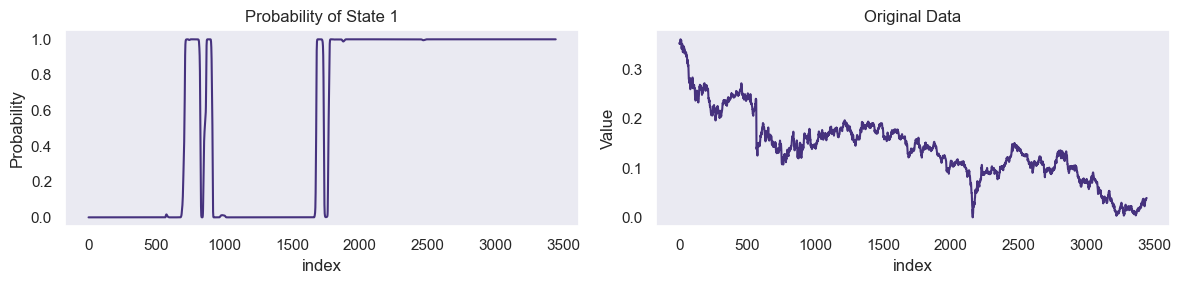

In [ ]:
pair = 'AUDCHF'
price = forex_daily_log[[pair]]
result_df, state_params = fit_hmm(price)
result_df

In [ ]:
prob_0 = result_df.iloc[:, 1]
prob_1 = result_df.iloc[:, 2]
prob_0

0       1.000000e+00
1       1.000000e+00
2       1.000000e+00
3       1.000000e+00
4       1.000000e+00
            ...     
3440    3.279029e-08
3441    3.359556e-08
3442    3.537040e-08
3443    1.462248e-07
3444    1.341447e-05
Name: Probability of state 0, Length: 3445, dtype: float64

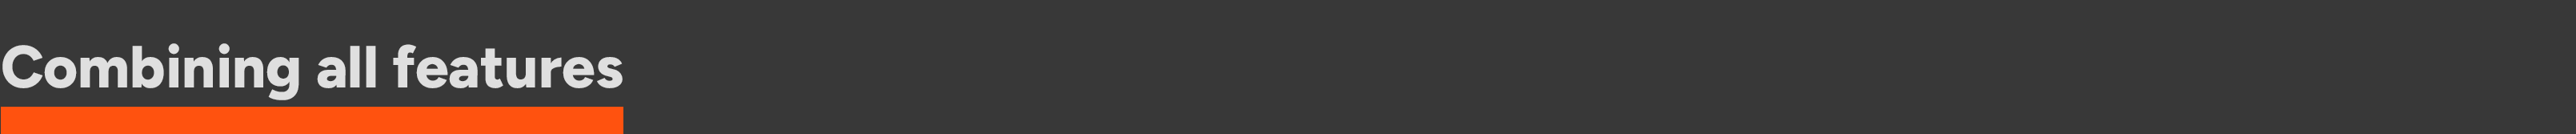

Model is not converging.  Current: 5544.015306059047 is not greater than 5544.019709786937. Delta is -0.004403727889439324


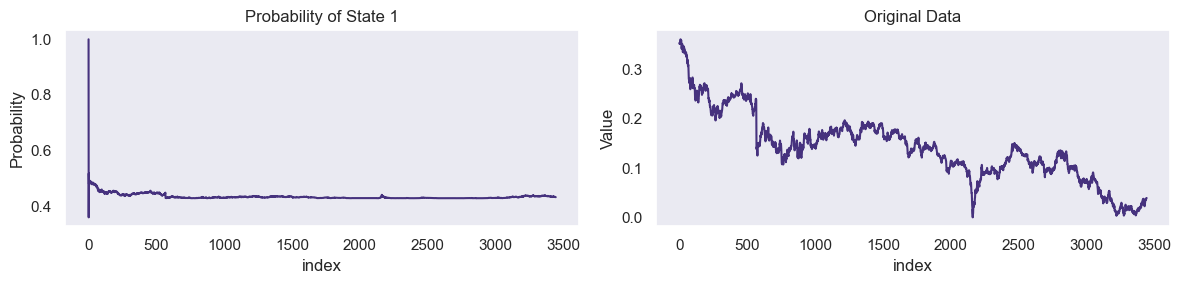

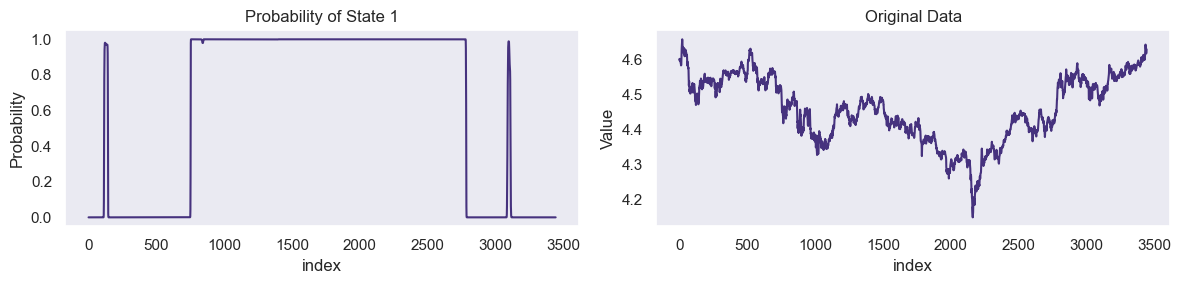

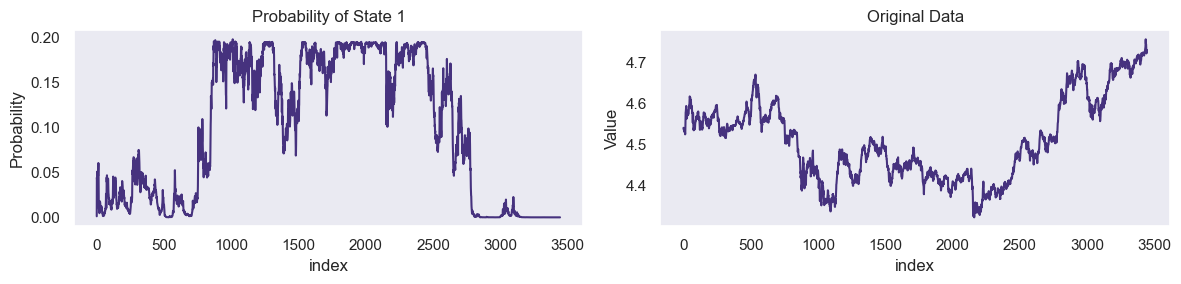

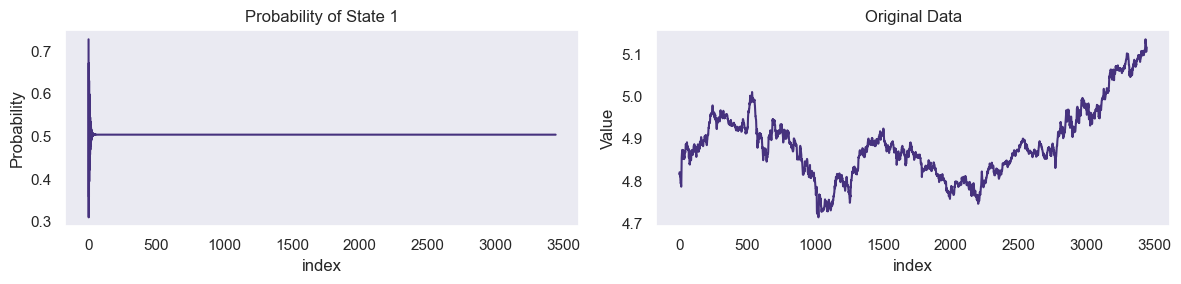

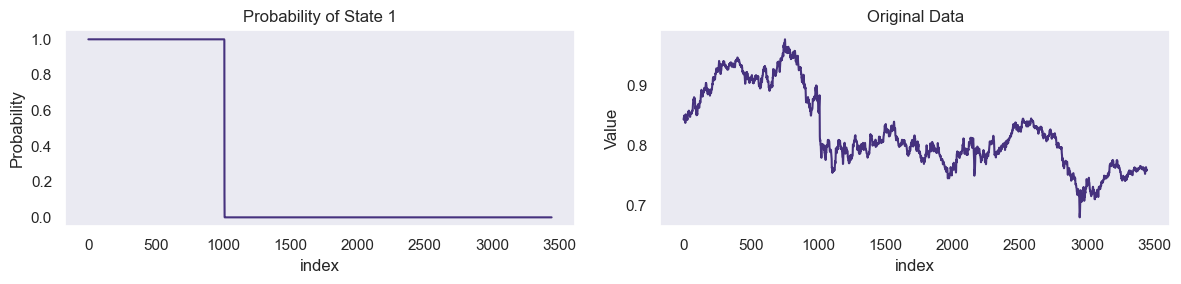

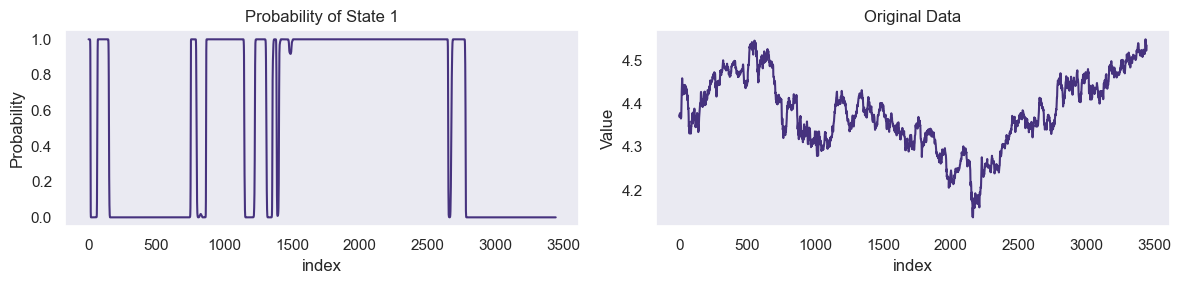

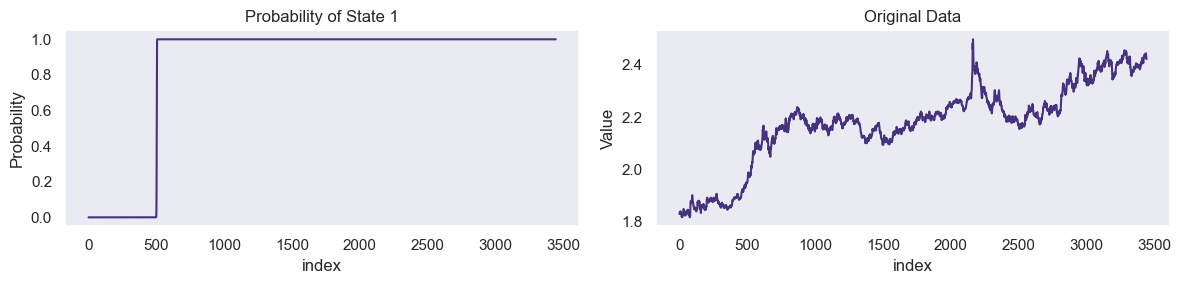

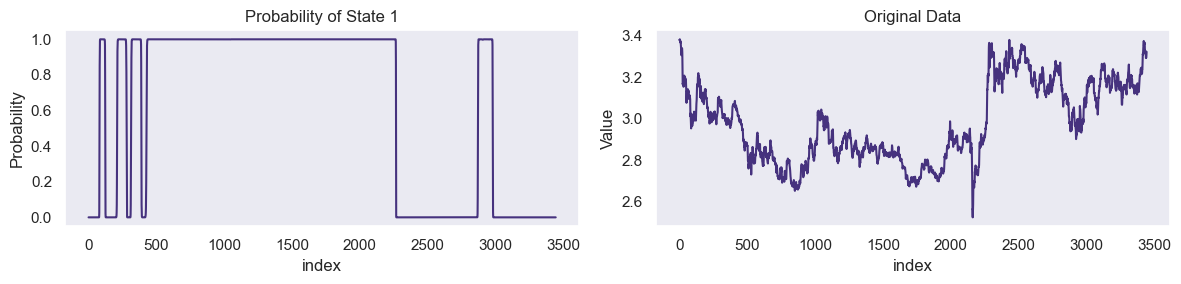

In [ ]:
for pair in forex_daily_log.columns:
    features = pd.DataFrame()
    price = forex_daily_log[pair]

    features['frac_diff'] = frac_diff_price_df[pair]
    features['sma_10'] = ta.trend.sma_indicator(price, window=10)
    features['sma_20'] = ta.trend.sma_indicator(price, window=20)
    features['ema_10'] = ta.trend.ema_indicator(price, window=10)
    features['ema_20'] = ta.trend.ema_indicator(price, window=20)
    hmm_result_df, _ = fit_hmm(price.values.reshape(-1, 1))

    features['prob_0'] = (hmm_result_df.iloc[:, 1]).values
    features['prob_1'] = (hmm_result_df.iloc[:, 2]).values

    features['rsi'] = ta.momentum.rsi(price)
    features['macd'] = ta.trend.macd_diff(price)
    features['bb_upper'] = ta.volatility.bollinger_hband(price)
    features['bb_middle'] = ta.volatility.bollinger_mavg(price)
    features['bb_lower'] = ta.volatility.bollinger_lband(price)

In [113]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf

def realised_volatility(price_series, window=21):
    """
    Calculate realised volatility from a price series.
    """
    log_returns = np.log(price_series / price_series.shift(1))
    vol = log_returns.rolling(window=window).std() * np.sqrt(252)
    return vol

def black_scholes_implied_vol(S, K, T, r, option_price, call=True):
    """
    Calculate implied volatility using Black-Scholes formula.
    """
    def bs_price(vol):
        d1 = (np.log(S / K) + (r + vol ** 2 / 2) * T) / (vol * np.sqrt(T))
        d2 = d1 - vol * np.sqrt(T)
        if call:
            price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
        else:
            price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
        return price

    implied_vol = np.zeros_like(option_price)
    for i in range(len(option_price)):
        price = option_price[i]
        vol = 0.5  # initial guess
        for _ in range(100):
            price_est = bs_price(vol)
            vega = S * norm.pdf((np.log(S / K) + (r + vol ** 2 / 2) * T) / (vol * np.sqrt(T))) * np.sqrt(T)
            vol -= (price_est - price) / vega
            if abs(price_est - price) < 1e-6:
                break
        implied_vol[i] = vol
    return implied_vol

In [117]:
AUDCHF = forex_daily_log['AUDCHF']
AUDCHF

Date
2013-03-18    0.353764
2013-03-19    0.351979
2013-03-20    0.351938
2013-03-21    0.354382
2013-03-22    0.354421
                ...   
2024-05-02    0.036857
2024-05-03    0.037517
2024-05-05    0.038241
2024-05-06    0.039296
2024-05-07    0.039265
Name: AUDCHF, Length: 3445, dtype: float64

In [ ]:
features

,frac_diff,sma_10,sma_20,ema_10,ema_20,prob_0,prob_1,rsi,macd,bb_upper,bb_middle,bb_lower
Date,,,,,,,,,,,,
2013-03-18,3.380834,NaN,NaN,NaN,NaN,1.0,7.999152e-44,NaN,NaN,NaN,NaN,NaN
2013-03-19,3.379179,NaN,NaN,NaN,NaN,1.0,6.634572e-11,NaN,NaN,NaN,NaN,NaN
2013-03-20,3.378001,NaN,NaN,NaN,NaN,1.0,6.825274e-11,NaN,NaN,NaN,NaN,NaN
2013-03-21,3.383443,NaN,NaN,NaN,NaN,1.0,5.992335e-11,NaN,NaN,NaN,NaN,NaN
2013-03-22,3.380518,NaN,NaN,NaN,NaN,1.0,6.425153e-11,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,3.294781,3.314640,3.337436,3.314119,3.317087,1.0,6.185560e-10,43.239625,-0.010781,3.388318,3.337436,3.286554
2024-05-03,3.294467,3.310602,3.334702,3.310546,3.314932,1.0,6.241857e-10,43.127432,-0.010288,3.388562,3.334702,3.280842
2024-05-05,3.295824,3.308678,3.332006,3.307869,3.313113,1.0,6.001950e-10,43.806410,-0.009468,3.387943,3.332006,3.276069


In [ ]:
features.isna().sum()

frac_diff     0
sma_10        9
sma_20       19
ema_10        9
ema_20       19
prob_0        0
prob_1        0
rsi          13
macd         33
bb_upper     19
bb_middle    19
bb_lower     19
dtype: int64

<div class="alert alert-info">

## <b>2. Strategy development</b>

</div>

<div class="alert alert-info">

## <b>3. Strategy backtesting</b>

</div>

<div class="alert alert-info">

## <b>4. Evaluating backtest overfitting</b>

</div>